# Preliminary predictions for each annotation category

# [With item numbers]

The point of this notebook is to use the usual random forest method to try and predict annotations for each annotation category in Grade2Spring. Some will be easy to predict and others will be harder.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [12]:
df_full = pd.read_csv('annotations-complete.tsv', sep='\t', skiprows=4).dropna(axis=1, how='all')

In [14]:
df = df_full.drop(['Stack', 'mlevel'], axis=1).dropna(subset=['Session', 'Response'], how='any')
df = df.astype({
    'Session': 'int',
    'level': 'int32',
    'Response': 'int',
    'Item': 'int'
})
df = df.astype({'Session': 'str', 'Response': 'str', 'Item': 'str'})
df = df.rename(columns={'WCPM.1': 'WCPM_response',
                        'Comp.1': 'Comp_response',
                        'Expression': 'Exp_response'})
df = df.sort_values(['Response'], axis='rows')
df = df.loc[df.Form == 'Grade2Spring']
print(df.shape[0], 'rows with Grade2Spring')
df = df.drop_duplicates()
print(df.shape[0], 'rows after removing duplicates')

3256 rows with Grade2Spring
1108 rows after removing duplicates


In [15]:
annotation_categories = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
category_desc = 'hiFrq	GradeLev	Applies	GradeCVe	Affixes	MultiSyl	Substit	Omit	Insert	Reverse	Rate	Rhythm	F-zero	Punctuation	FS&word	Line	Long	easyHard	Effort	Assisted'.split('\t')
category_to_desc = {str(idx + 1): x for idx, x in enumerate(category_desc)}
def infer_num_possible_labels(column):
    return len(set(x for x in column if x == x))

In [16]:
TERNARY_LABEL_TO_INDICATOR = {
    'undetermined': lambda x: 1 in x and 3 in x,
    '1_unanimous':  lambda x: set(x) == {1},
    '1_or_2':       lambda x: set(x) == {1, 2},
    '2_unanimous':  lambda x: set(x) == {2},
    '2_or_3':       lambda x: set(x) == {2, 3},
    '3_unanimous':  lambda x: set(x) == {3}
}

BINARY_LABEL_TO_INDICATOR = {
    '1_unanimous': lambda x: set(x) == {1},
    '1_or_2':      lambda x: set(x) == {1, 2},
    '2_unanimous': lambda x: set(x) == {2}
}

def add_labels_for_prediction(response_column, category_column, num_labels=3):
    response_to_scores = defaultdict(set)
    for response, score in zip(response_column, category_column):
        response_to_scores[response].add(score)
        
    response_to_added_label = defaultdict(set)
    LABEL_DICT = TERNARY_LABEL_TO_INDICATOR if num_labels == 3 else BINARY_LABEL_TO_INDICATOR
    
    for response, scores in response_to_scores.items():
        added = 0
        for label, indicator in LABEL_DICT.items():
            if indicator(scores):
                response_to_added_label[response].add(label)
                added += 1
        assert added == 1
    
    for response, added_label in response_to_added_label.items():
        assert len(added_label) == 1
    
    column_to_insert = [
        list(response_to_added_label[response])[0]
        for response in response_column
    ]
    
    column_names = [name for name in LABEL_DICT]
    
    return column_to_insert, column_names
        

In [20]:
def run_classifier(df_raw, category_to_predict):
    print('Classifying:', category_to_predict)
    df = df_raw[df_raw[category_to_predict].notna()]
    df = df.astype({category_to_predict: 'int'})
    
    num_possible_labels = infer_num_possible_labels(df[category_to_predict])
    
    column_to_insert, column_names = add_labels_for_prediction(
        df.Response,
        df[category_to_predict],
        num_possible_labels
    )
    
    df['to_predict'] = column_to_insert
    one_hot = pd.get_dummies(df.to_predict)
    df = df.join(one_hot)
    
    X = df[[
        'Response', 'WCPM', 'Acc', 'Comp', 'Exp', 'level', 'WCPM_response', 'Comp_response', 'Exp_response'
    ]]
    column_names = [x for x in column_names if x in df.columns]
    Y = df[column_names]
    
    out_df = X.join(Y)
    out_df.to_csv(category_to_predict + '_table.csv', index=False)
    
    X = X.drop('Response', axis='columns')
    
    ACCURACIES = []
    NUM_COUNTS = [] # to find distribution of labels
    for column_name in column_names:
        y = Y[column_name]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=0)
        
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        
        accuracy = clf.score(X_test, y_test)
        ACCURACIES.append(accuracy)
        NUM_COUNTS.append(sum(y))
    
    return_dict = {
        'columns': column_names,
        'accuracies': ACCURACIES,
        'distribution': NUM_COUNTS
    }
    
    return return_dict

Classifying: 1


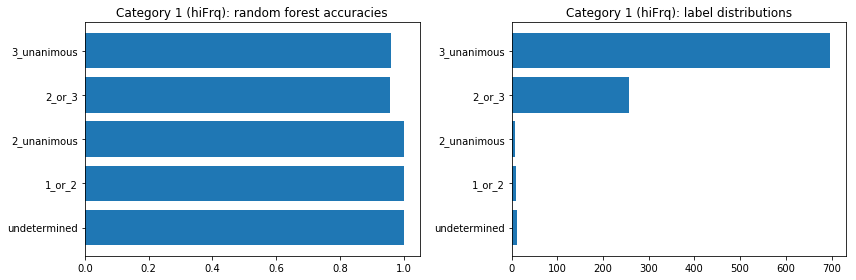

Classifying: 2


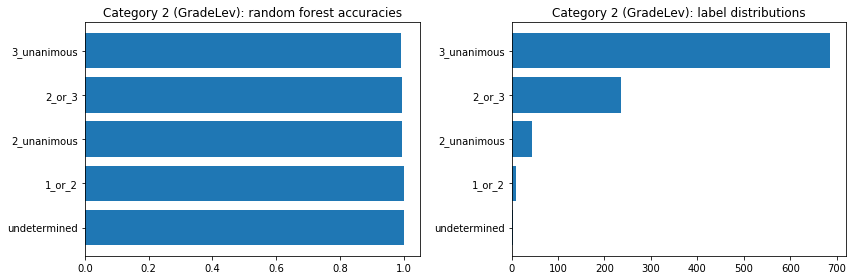

Classifying: 3


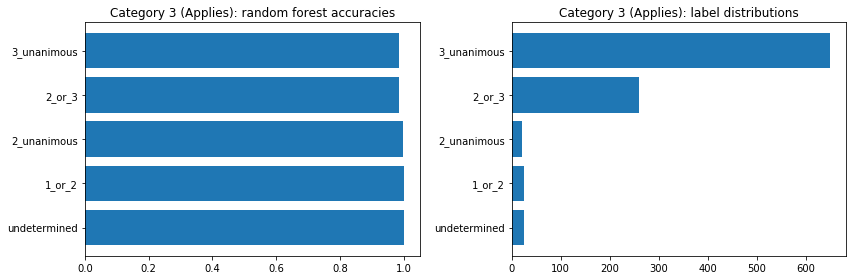

Classifying: 4


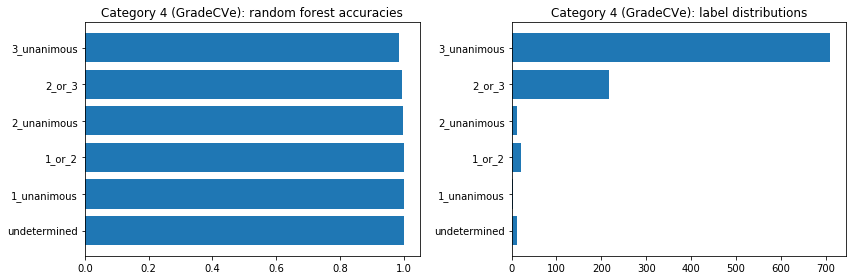

Classifying: 5


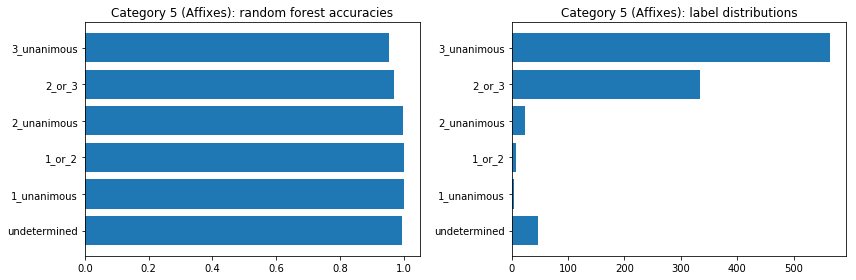

Classifying: 6


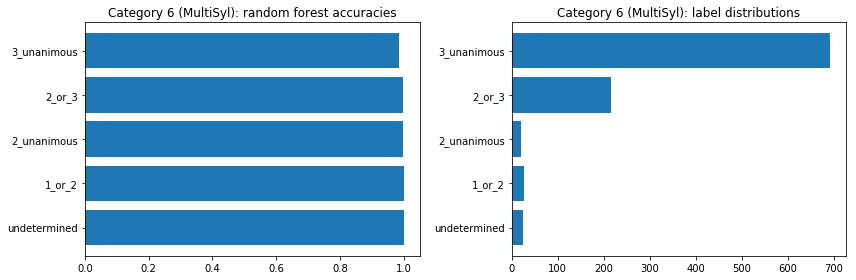

Classifying: 7


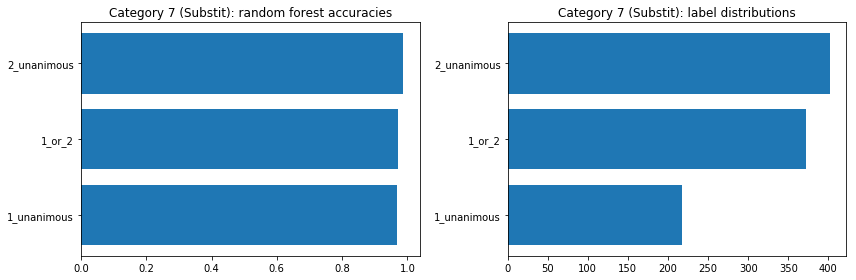

Classifying: 8


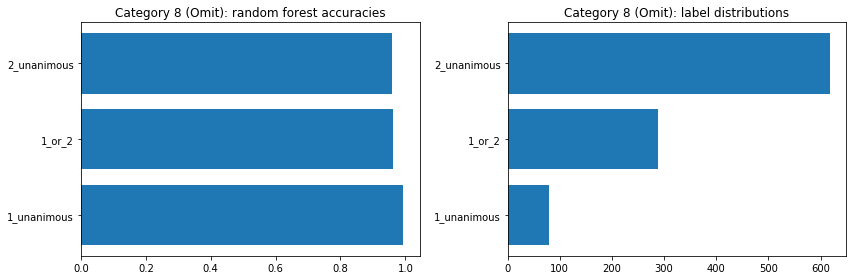

Classifying: 9


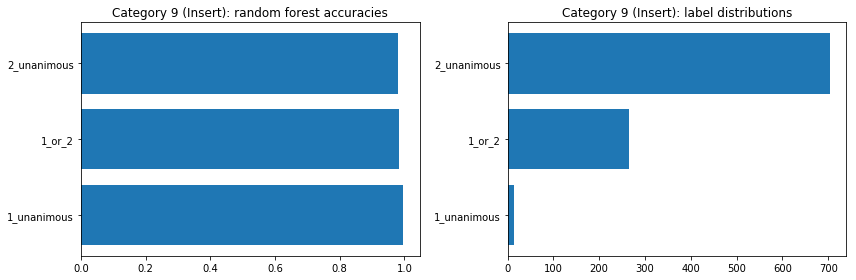

Classifying: 10


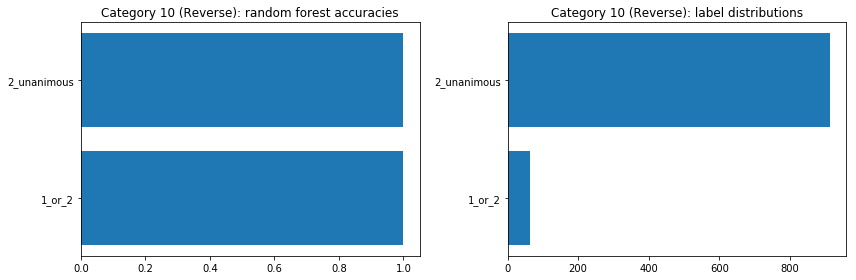

Classifying: 11


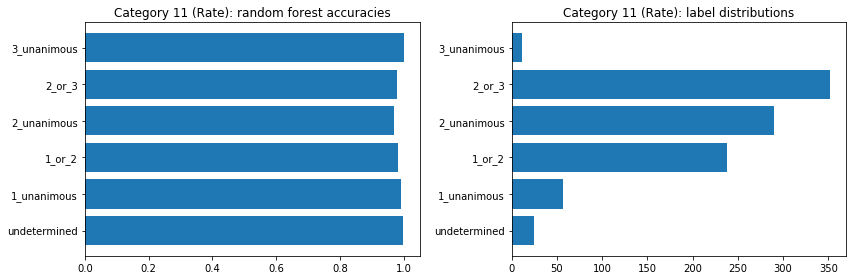

Classifying: 12


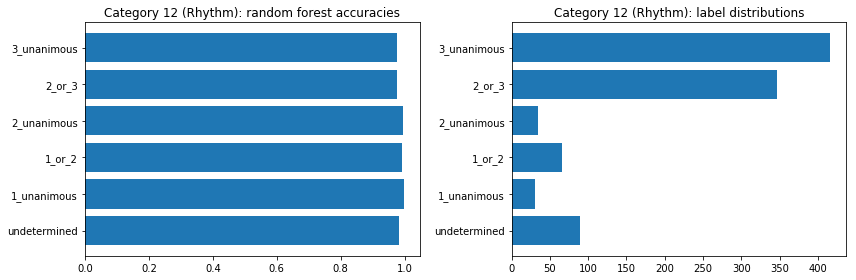

Classifying: 13


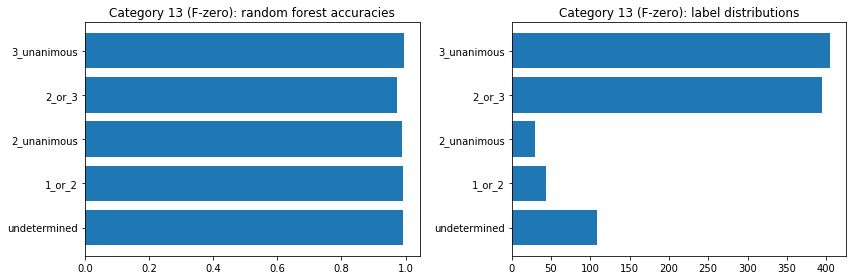

Classifying: 14


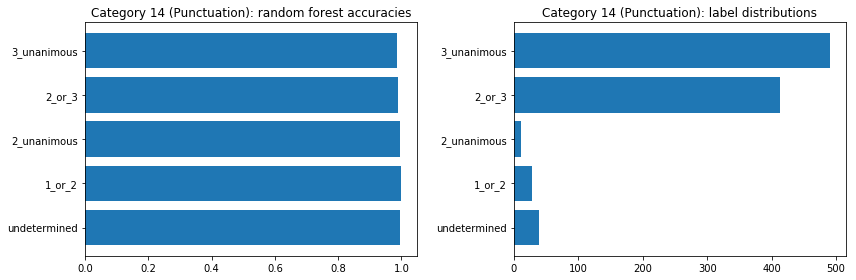

Classifying: 15


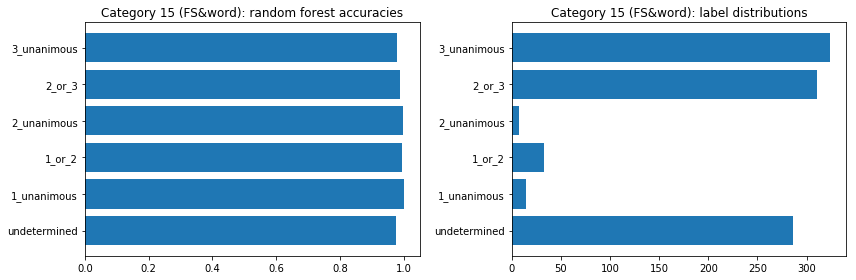

Classifying: 16


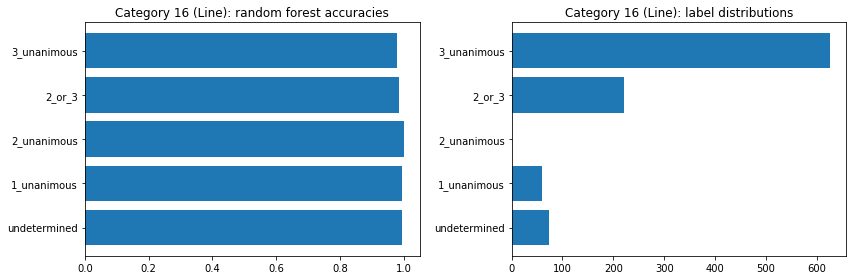

Classifying: 17


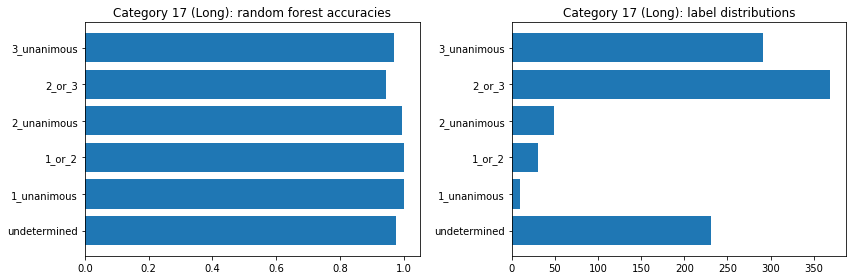

Classifying: 18


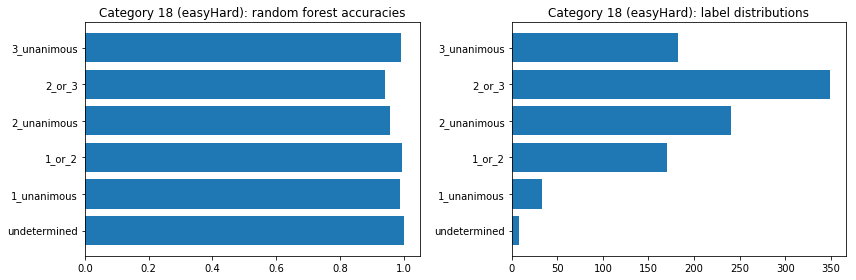

Classifying: 19


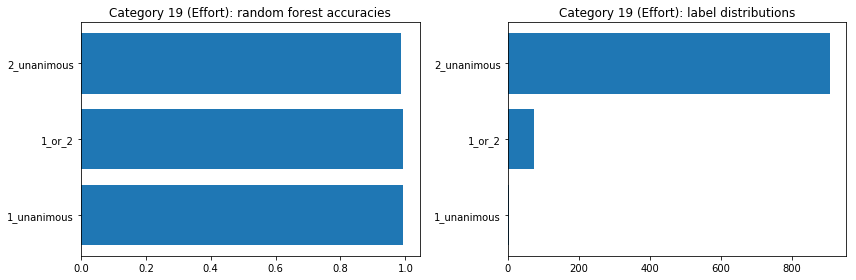

Classifying: 20


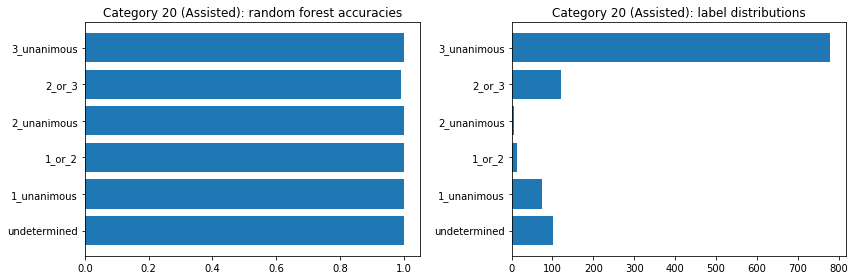

In [21]:
for category in annotation_categories:
    classifier_info = run_classifier(df, category)
    columns, accuracies, distribution = classifier_info['columns'],\
        classifier_info['accuracies'], classifier_info['distribution']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    title = 'Category {} ({}):'.format(category, category_to_desc[category])
    ax1.set_title(title + ' random forest accuracies')
    ax2.set_title(title + ' label distributions')
    ax1.barh(columns, accuracies)
    ax2.barh(columns, distribution)
    fig.tight_layout()
    plt.show()